### Imports

In [29]:
import torch
import torch_geometric
import torch.nn as nn
import explainer
import networks
import datasetLoader
import evaluation
import importlib
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import networkx as nx
from typing import Literal
import torch.nn.functional as fn
from torch_geometric.utils import k_hop_subgraph
import utils
import wandb

importlib.reload(datasetLoader)
importlib.reload(networks)
importlib.reload(explainer)
importlib.reload(utils)
importlib.reload(evaluation)

<module 'evaluation' from 'c:\\Users\\trist\\Git_repos\\BT-ML-PGESAT\\code\\PGExplainer\\evaluation.py'>

### Parameters Explainer

In [2]:
batch_size = 16
sampled_graphs = 20

learning_rate_mlp = 0.003       #Paper: 0.003,
coefficientSizeReg = 0.05       #Paper: 0.05, code 0, codePyG 0.03
entropyReg = 0.01               #Paper: 1, code 0, codePyG 0.01
epochs_mlp = 20                 #Paper: 30 for all datasets => 20 enough for BA2Motif

# Temperature
t_0 =  5.0
t_T = 1.0                       #Paper says 2.0, Code seems to use 1.0 => 1.0 seems to work good

datasetName: Literal['BA2Motif','MUTAG'] = 'BA2Motif'
MUTAG = False

### Load and visualize data

Data(x=[25, 10], edge_index=[2, 52], y=[1])


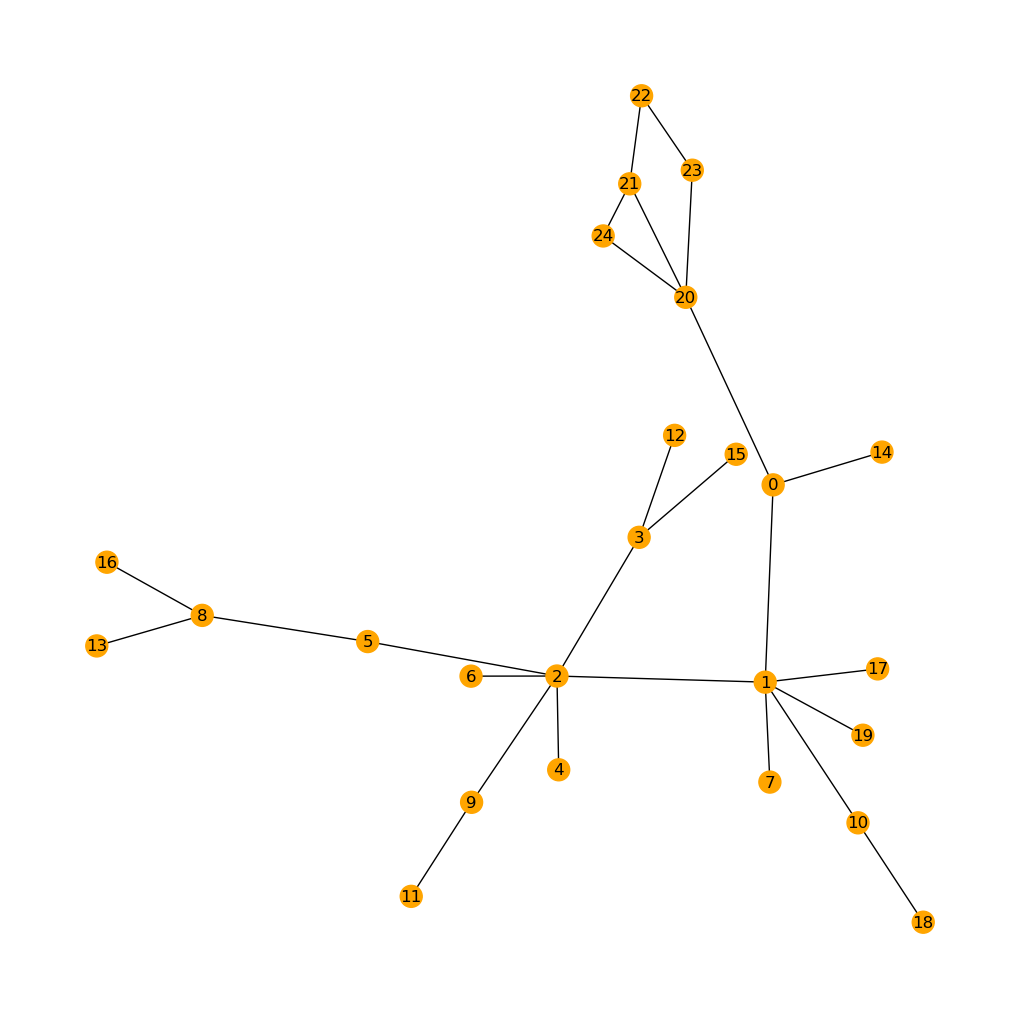

In [11]:
train_dataset, val_dataset, test_dataset = datasetLoader.loadGraphDataset(datasetName)               # TODO: adjs matrix is not compatible with GraphConv. Needs to be converted to edge_index (see RE_PGE datasets/utils)

print(train_dataset[0])

graph = Data(train_dataset[0].x, train_dataset[0].edge_index)

utils.plotGraphAll(graph, number_nodes=True, graph_task=True)
#utils.plotGraph(graph, color_map=None, MUTAG=MUTAG)

train_loader = DataLoader(train_dataset, batch_size, True)             # TODO: Data not shuffled to match calculated embeddings to correct graphs! Should work now, as embeddings are calculated on the fly per batch
val_loader = DataLoader(val_dataset, batch_size, False)
test_loader = DataLoader(test_dataset, batch_size)

### Load GNN model

In [12]:
modelGraphGNN = networks.GraphGNN(features = train_dataset[0].x.shape[1], labels=2)     # Adjust according to data and task
modelGraphGNN.load_state_dict(torch.load("models/BA2Motif 100", weights_only=True))

<All keys matched successfully>

### Training Loop Graph Classification Explainer

In [15]:
#torch.set_printoptions(threshold=10_000)
wandb.init(
    # set the wandb project where this run will be logged
    project="Explainer-Training",

    # track hyperparameters and run metadata
    config={
    "learning_rate": learning_rate_mlp,
    "architecture": "MLP",
    "dataset": datasetName,
    "batch_size": batch_size,
    "epochs": epochs_mlp,
    "#sampled_graphs": sampled_graphs,
    "size_regularization": coefficientSizeReg,
    "entropy_regularization": entropyReg,
    "initial_temperature": t_0,
    "final_temperature": t_T,
    }
)

mlp = explainer.MLP()

wandb.watch(mlp, log= "all", log_freq=2, log_graph=False)

mlp_optimizer = torch.optim.Adam(params = mlp.parameters(), lr = learning_rate_mlp, maximize=False)

modelGraphGNN.eval()
for param in modelGraphGNN.parameters():
    param.requires_grad = False

for epoch in range(0, epochs_mlp) :
    mlp.train()
    mlp_optimizer.zero_grad()

    temperature = t_0*((t_T/t_0) ** ((epoch+1)/epochs_mlp))

    for batch_index, data in enumerate(train_loader):
        # MLP forward                                                           # shape embeddings[batch_index]: ~50 X 40 = Edges X hidden_embs_2Nodes
        w_ij = mlp.forward(modelGraphGNN, data.x, data.edge_index)               # shape: ~50 X 1 = Edges X MLP_out(edge_weight)

        sampleLoss = torch.FloatTensor([0])
        loss = torch.FloatTensor([0])
        
        for k in range(0, sampled_graphs):
            # Sample with reparam trick via edge weights
            edge_ij = mlp.sampleGraph(w_ij, temperature)

            # TODO: This softmax is needed for the prediction of the downstream task and should probably be moved into the GNN model!!!
            # until then it is def needed here. Probably correct here, can also be found in og Explainer.call
            # TODO: Validate correct prediction on batches!!!
            pOriginal = fn.softmax(modelGraphGNN.forward(data.x, data.edge_index, data.batch), dim=1)
            pSample = fn.softmax(modelGraphGNN.forward(data.x, data.edge_index, data.batch, edge_weights=edge_ij), dim=1)

            # TODO: Validate loss function, True_one_hot labels needed??
            # TODO: Implement correct loss for each graph per batch => Should be good
            for graph_index in range(data.num_graphs):
                node_mask = data.batch == graph_index
                edge_mask = (node_mask[data.edge_index[0]] & node_mask[data.edge_index[1]])

                # TODO: VALIDATE pOriginal and pSample pass both label predictions, not just correct one
                currLoss = mlp.loss(pOriginal[graph_index], pSample[graph_index], edge_ij[edge_mask], coefficientSizeReg, entropyReg)
                sampleLoss += currLoss
        
        loss += sampleLoss / sampled_graphs
        
    #loss = loss / len(train_loader.dataset)
    
    loss.backward()
    
    #Loss = Loss / len(train_loader.dataset)

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

    #torch.nn.utils.clip_grad_norm_(mlp.parameters(), max_norm=2)

    mlp_optimizer.step()

    mlp.eval()
        
    dataOut, meanAuc = evaluation.evaluateExplainerAUC(mlp, modelGraphGNN, val_dataset, MUTAG)
    
    wandb.log({"train/Loss": loss, "val/mean_AUC": meanAuc})
    
    #out = mlp.forward(modelGraphGNN, val_dataset[0].x, val_dataset[0].edge_index)

    #print(f"MLP Output for first val graph in epoch {epoch+1}:")
    #print(out.squeeze(1))

    """for name, param in mlp.named_parameters():
        if param.requires_grad:
            print(f"{name}: {param.grad}")"""
            
wandb.finish()

wandb: Currently logged in as: tristan-schulz2001 (tristan-schulz2001-tu-dortmund) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch 1, Loss: 35.85776138305664
AUC of ROC: 0.2235492616891861
BinaryAUROC: 0.4816471275546009
Mean roc_auc_score for dataset: 0.512634008097166
Epoch 2, Loss: 50.67948913574219
AUC of ROC: 0.24105937778949738
BinaryAUROC: 0.48489859966728294
Mean roc_auc_score for dataset: 0.5154745614035088
Epoch 3, Loss: 43.341102600097656
AUC of ROC: 0.27945345640182495
BinaryAUROC: 0.4898457176037247
Mean roc_auc_score for dataset: 0.5195391363022942
Epoch 4, Loss: 39.023765563964844
AUC of ROC: 0.35595476627349854
BinaryAUROC: 0.5082288694388338
Mean roc_auc_score for dataset: 0.5315181511470984
Epoch 5, Loss: 38.83187484741211
AUC of ROC: 0.6268016695976257
BinaryAUROC: 0.5850432282816624
Mean roc_auc_score for dataset: 0.6056651147098515
Epoch 6, Loss: 31.642093658447266
AUC of ROC: 0.9244938492774963
BinaryAUROC: 0.7098486386742614
Mean roc_auc_score for dataset: 0.7076234143049932
Epoch 7, Loss: 36.81968307495117
AUC of ROC: 0.9906376600265503
BinaryAUROC: 0.7418423761840132
Mean roc_auc_sco

train/Loss,▂▅▃▃▃▁▂▃▃▃▄▄▆█▃▁▃▂▃▂
val/mean_AUC,▁▁▁▂▄▇█▇▇▆▆▆▆▆▇▇▇▇▇▇
train/Loss,32.07558
val/mean_AUC,0.70769


In [28]:
torch.save(mlp.state_dict(), f"models/compare/explainerBA2Motif_64arch_Size05Ent01_tT1_AUC70_LEARNS_NOTHING")

In [14]:
mlp = explainer.MLP(GraphTask=True)     # Adjust according to data and task
mlp.load_state_dict(torch.load("models/explainerBA2Motif_sequential_batched64", weights_only=True))

RuntimeError: Error(s) in loading state_dict for MLP:
	size mismatch for model.0.weight: copying a param with shape torch.Size([20, 40]) from checkpoint, the shape in current model is torch.Size([64, 40]).
	size mismatch for model.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for model.2.weight: copying a param with shape torch.Size([1, 20]) from checkpoint, the shape in current model is torch.Size([1, 64]).

In [38]:
k = 5

data1 = test_dataset[32]

printLoader = DataLoader([data1], 1, False)

tensor([-6.3077, -3.5352, -6.2511, -6.3077, -5.3312, -5.3312, -5.3312, -6.3625,
        -5.3039, -5.3312, -5.3312, -5.3312, -3.5352, -5.3312, -5.3312, -6.3625,
        -3.8679, -3.9852, -3.5109, -5.3039, -2.5436, -3.8679, -2.7919, -2.7919,
        -5.3312, -3.9852, -2.6521, -2.6521, -5.3312, -2.7919, -2.5136, -2.6521,
        -2.5136, -3.5109, -2.7919, -2.5136, -2.5136, -2.6521, -2.5436, -6.2511,
        -7.7552, -6.6730, -7.9023, -7.7552, -5.8761, -7.3683, -5.8761, -4.6972,
        -6.6730, -4.6972, -7.9023, -7.3683], grad_fn=<CopySlices>)
tensor([0.0018, 0.0283, 0.0019, 0.0018, 0.0048, 0.0048, 0.0048, 0.0017, 0.0049,
        0.0048, 0.0048, 0.0048, 0.0283, 0.0048, 0.0048, 0.0017, 0.0205, 0.0182,
        0.0290, 0.0049, 0.0729, 0.0205, 0.0578, 0.0578, 0.0048, 0.0182, 0.0659,
        0.0659, 0.0048, 0.0578, 0.0749, 0.0659, 0.0749, 0.0290, 0.0578, 0.0749,
        0.0749, 0.0659, 0.0729, 0.0019, 0.0004, 0.0013, 0.0004, 0.0004, 0.0028,
        0.0006, 0.0028, 0.0090, 0.0013, 0.0090, 0.000

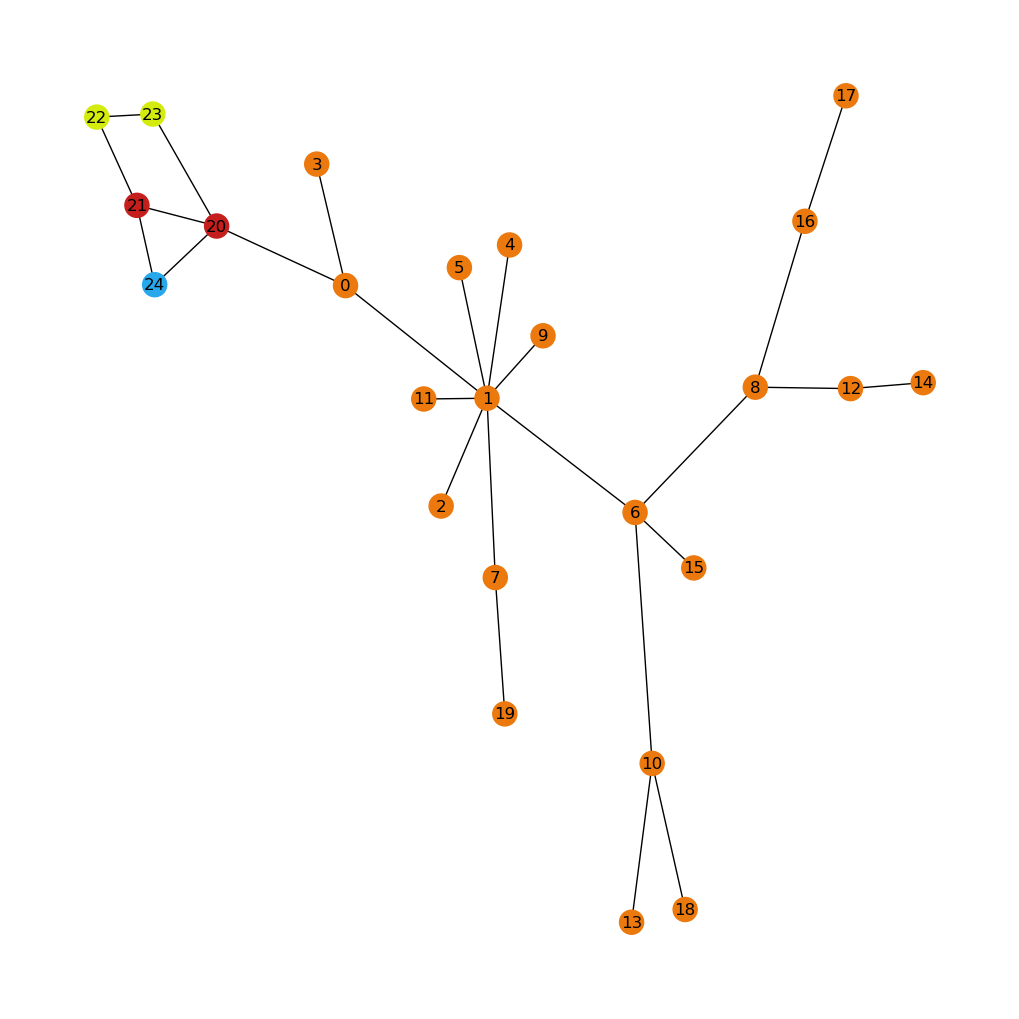

-----------------Sampled Graph-----------------


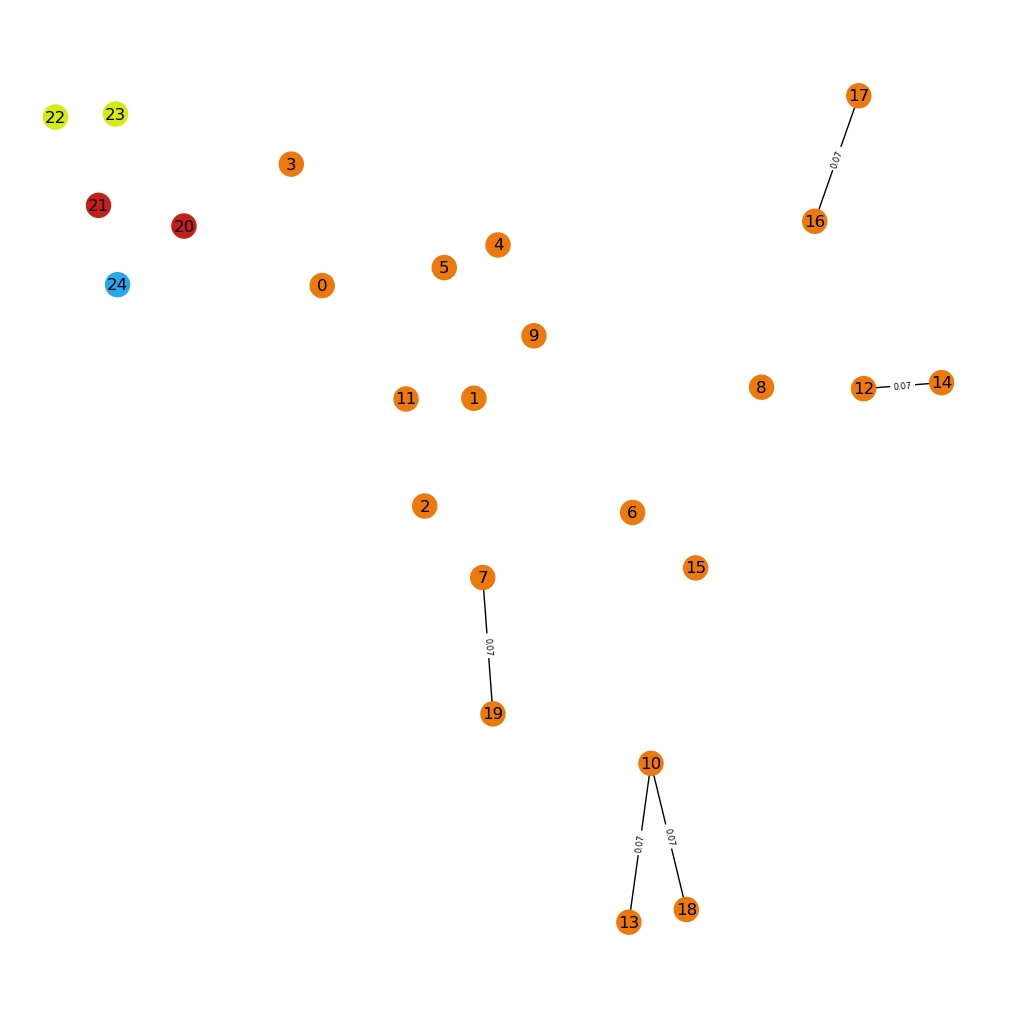

In [39]:
mlp.eval()
modelGraphGNN.eval()

w_ij = mlp.forward(modelGraphGNN, data1.x, data1.edge_index)

print(w_ij)

edge_ij = mlp.sampleGraph(w_ij, temperature)
print(edge_ij)

_, top_k_indices = torch.topk(edge_ij, k=k*2, largest=True)

mask = torch.zeros_like(edge_ij, dtype=torch.bool)
mask[top_k_indices] = True

sortedTopK, indices = torch.sort(top_k_indices)

edge_index_masked = data1.edge_index[:,mask]
weights_masked = edge_ij[sortedTopK]                # This is ordered by size

# edge_index_masked and weights_masked to display top 5 edges; data1.edge_index and w_ij to display original graph
Gs = Data(x=data1.x, edge_index=edge_index_masked, edge_attr=weights_masked)

#print(Gs.edge_attr)
#print(weights_masked)

print("-----------------Original Graph-----------------")

#pos = utils.plotGraph(data1, MUTAG=MUTAG)
pos = utils.plotGraphAll(data1, number_nodes=True, graph_task=True)

print("-----------------Sampled Graph-----------------")

#pos1 = utils.plotGraph(Gs, pos=pos, color_map=None, edge_weights=True, MUTAG=MUTAG)
pos1 = utils.plotGraphAll(Gs, pos=pos, number_nodes=True, graph_task=True, edge_weights=True)

-----------------3 Hop neighbourhood-----------------


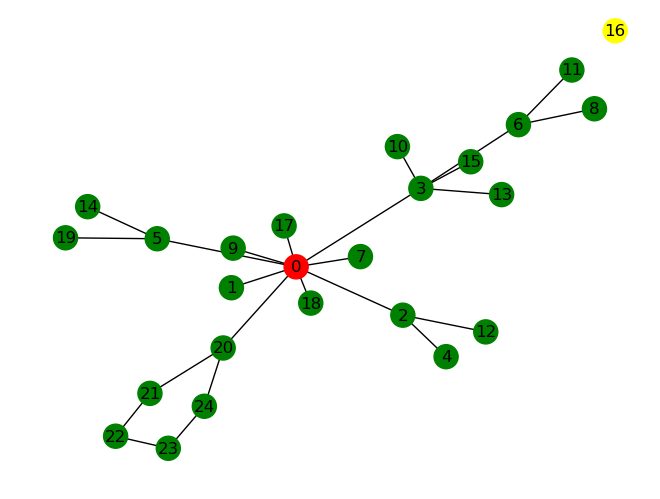

In [12]:
startNode = 0

print("-----------------3 Hop neighbourhood-----------------")

posH, G_hop = utils.plotKhopGraph(startNode, data1.x, data1.edge_index, pos=pos, color_map=None)

#### Calculate AUC between explanation edge probabilites and ground truth edges

AUC of ROC: 0.7673321962356567
BinaryAUROC: 0.6485774062350639
Mean roc_auc_score for dataset: 0.6226015396883818


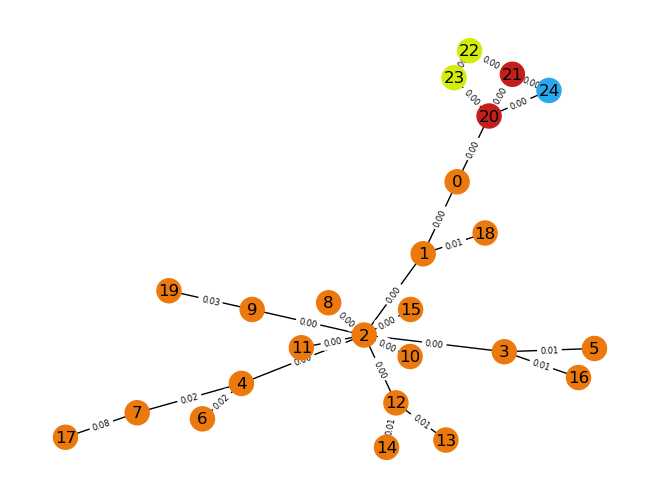

In [13]:
import evaluation
importlib.reload(evaluation)
# TODO: Work on different batch sizes

# TODO: Not working? Flips edge weights
data, t = evaluation.evaluateExplainerAUC(mlp, modelGraphGNN, test_dataset, MUTAG)
w_ij = mlp.forward(modelGraphGNN, data.x, data.edge_index)
edge_ij = mlp.sampleGraph(w_ij, temperature)

Graph = Data(x=data.x,edge_index=data.edge_index,edge_attr=edge_ij.detach())
pos1 = utils.plotGraph(Graph, pos=None, color_map=None, edge_weights=True, MUTAG=MUTAG)